## Управление с прогнозируюшими моделями

Управление с прогнозирующими моделями подразумевает:
* наличие внутренней динамической (прогнозирующей) модели процесса $\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x},\mathbf{u},t)$

* выбор целевой функции $J$ для оптимизации на основе прогнозирующей модели на конечном интервале времени (как правило соответствующем определённому числу тактов управления $P$, $P$ называется горизонтом прогноза)

* выбор алгоритма оптимизации при помощи которого определяется минимум целевой функции $J$ по управлению $u$ на интервале времени $t \in [t_{k}, t_{k+P}]$

На каждом такте управления $t \in [t_{k}, t_{k+1}]$ решается задача оптимизации (возможно условной с любыми ограничениями на компоненты фазового вектора и управляющие параметры) после чего в качестве значения функции управления на этом такте принимается равным $\mathbf{u}_k$, полученным как $\mathrm{argmin} J$ на первом из $P$ тактов, вошедших в решение оптимизационной задачи.

В качестве примера целевой функции может быть рассмотрена

$$J = \sum_{k=1}^P{w_{x_k}}(\mathbf{r}_k - \mathbf{x}_k)^2 + \sum_{k=1}^P{w_{u}}(\mathbf{u}_{max} - \mathbf{u}_k)^2,$$

где

$\mathbf{x}_k$ - значения вектора фазовых пременных системы на такте $k$,

$\mathbf{r}_k$ - задающий сигнал, который должна воспроизводить система управления,

$\mathbf{u}_k$ - значения вектора управляющих параметров системы на такте $k$,

$\mathbf{u}_{max}$ - значения ограничений на компоненты вектора управляющй параметров системы,

$w_{x_k}$, $w_{u}$, - вестовые коэффициенты.

## Пример. Обращенный маятник на тележке

### Обозначения
$s : смещение \ тележки\ [м]; $ 

$\alpha : угол,\ который\ образует\ маятник\ с\ вертикалью\ [rad]; $

$u  : сила,\ приложенная\ к\ тележке,\ действующая\ как\ управляющий\ вход\ [Н]; $

$m  : масса\ тележки\ [кг]; $

$M  :  масса\ маятника\ [кг]; $

$l : длина\ маятника\ [м]; $

$g : ускорение\ свободного\ падения\ [м/с^2]; $

### Уравнения Лагранжа

Кинетическая энергия
$$T = \frac{m}{2}\left[(l\dot{\alpha}\cos{\alpha}+ \dot{s})^2 + (l\dot{\alpha}\sin{\alpha})^2\right] + \frac{M}{2}\dot{s}^2$$


Потенциальная энергия
$$\Pi = mgl\cos{\alpha}$$


Уравнения Лагранжа
$$
\begin{array}\\
ml^2\ddot{\alpha} + ml\ddot{s}\cos{\alpha} - ml\dot{s}\dot{\alpha}\sin{\alpha}- mgl\sin{\alpha} = 0 \\
ml\ddot{\alpha}\cos{\alpha} + (m + M)\ddot{s} - ml\dot{\alpha}^2\sin{\alpha} = u
\end{array}
$$

В нормальной форме Коши уравнения обращённого маятника имеют вид:
$$\left\{ 
\begin{array}\\
\dot{\alpha} = \omega \\
\dot{\omega} = \frac{1}{(M+m\sin{\alpha}^2)l} \left[(M+m)g\sin{\alpha} - ml\omega^2\sin{\alpha}\cos{\alpha}-u\cos{\alpha}\right] \\
\dot{s} = v \\
\dot{v} = \frac{1}{(M+m\sin{\alpha}^2)} \left[-mg\sin{\alpha}\cos{\alpha} + ml\omega^2\sin{\alpha} + u\right]
\end{array}
\right. 
$$

In [1]:
import numpy as np
import scipy as sci
from scipy.integrate import solve_ivp 
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### Параметры модели и настройки моделирования

In [2]:
class Parameters(object):
    pass
sim = Parameters()
sim.time = 20
sim.step = 0.1
sim.t = np.arange(0, sim.time, sim.step)
sim.loop_count = len(sim.t)
sim.output = False

cnst = Parameters()
cnst.g = 9.81
cnst.m = 1
cnst.M = 10
cnst.L = 1
cnst.u_max = 50

### Правая часть уравнений движения

In [3]:
def rhs(t, x, u=0):   
    cosA = np.cos(x[0])
    sinA = np.sin(x[0])
    p = cnst
    
    x_dot = np.zeros(4)
    
    x_dot[0] = x[1]
    x_dot[1] = ( (p.M + p.m) * p.g * sinA - p.m * p.L * x[1]**2 * sinA * cosA - u * cosA ) / (p.M + p.m * sinA**2) / p.L
    x_dot[2] = x[3]
    x_dot[3] = ( -p.m * p.g * sinA * cosA + p.m * p.L * x[1]**2 * sinA + u ) / (p.M + p.m * sinA**2)
    
    return x_dot

### Визуализация результатов интегрирования уравнений движения

In [4]:
def plot_results(time_array, state_array, control, sim_params):

    fig1 = plt.figure(figsize=(16,8))
    ax1 = fig1.add_subplot(2,2,1)

    ax1.set_title("Angle")
    ax1.plot(time_array, state_array[:, 0] * 180. / np.pi, label = r'$ \alpha $', color = 'red')
    ax1.set_ylabel(r'angle, [deg]')
    ax1.set_xlabel(r't, [s]')
    ax1.grid(True)
    ax1.legend()

    ax2 = fig1.add_subplot(2,2,2)

    ax2.set_title("Angular Velocity")
    ax2.plot(time_array, state_array[:, 1], label = '$\omega$', color = 'red')
    ax2.set_ylabel(r'angular velocity, [rad/s]')
    ax2.set_xlabel(r't, [s]')
    ax2.grid(True)
    ax2.legend()

    ax3 = fig1.add_subplot(2,2,3)

    ax3.set_title("Trolley Position")
    ax3.plot(time_array, state_array[:, 2], label = '$s$', color = 'red')
    ax3.set_ylabel(r's, [m]')
    ax3.set_xlabel(r't, [s]')
    ax3.grid(True)
    ax3.legend()

    ax4 = fig1.add_subplot(2,2,4)

    control_upper_bound = np.ones(np.size(time_array)) * sim_params.u_max
    control_lower_bound = -control_upper_bound

    ax4.set_title("Control Action")
    ax4.plot(time_array, control, label = '$u$', color = 'red')
    ax4.plot(time_array, control_upper_bound, linestyle = '--', color = 'black')
    ax4.plot(time_array, control_lower_bound, linestyle = '--', color = 'black')
    ax4.set_ylabel(r'u, [Nm]')
    ax4.set_xlabel(r't, [s]')
    ax4.grid(True)

    plt.tight_layout()

### Пример движения системы без управления

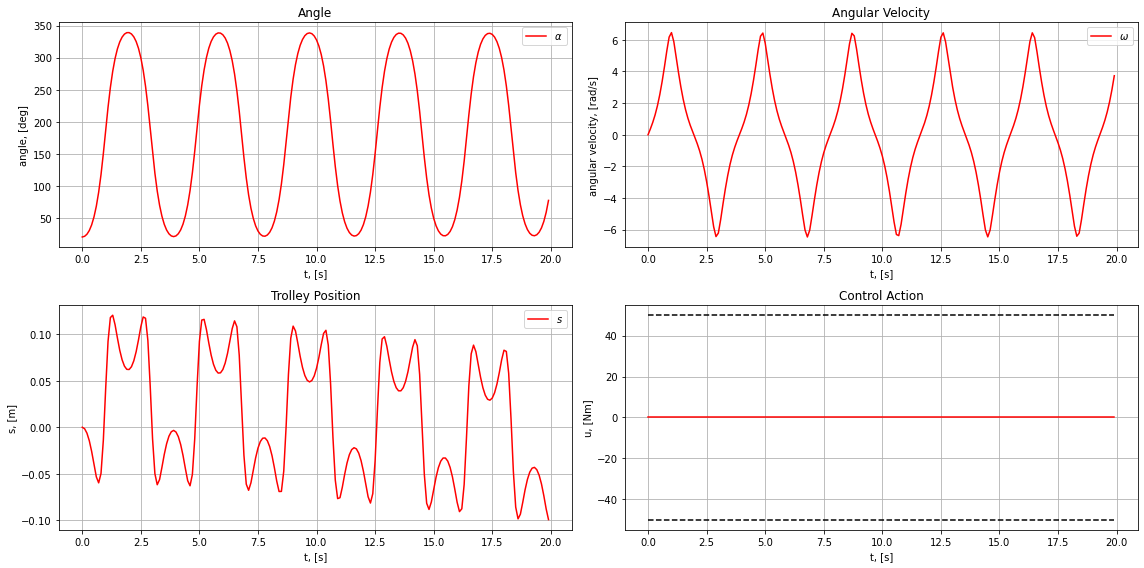

In [6]:
x0 = np.array([ np.pi * 20 / 180, 0, 0, 0])


sol_no_control = solve_ivp(lambda t, x: rhs(t, x), [0, sim.time], x0, t_eval = sim.t)
sim_time = sol_no_control.t
sim_states = sol_no_control.y.T
u = np.zeros(np.size(sim_time))

plot_results(sim.t, sim_states, u, cnst)

### Настройки MPC

#### Структура mpc ниже содержит параметры, определяющие состав целевой функции и интервал, на котором производится решение оптимизационной задачи:

In [7]:
mpc = Parameters()
mpc.p_horizon = 10          # горизонт прогноза
mpc.c_horizon = 8           # горизонт управления 
mpc.constraintpenalty = 0   # штраф за превышение ограничений на управление при составлении целевой функции в оптимизации
mpc.movepenalty = 0         # штраф за изменение управления на одном шаге при составлении целевой функции в оптимизации
mpc.strongfinish = 0        # штраф за отклонение последнего значения от цели

### Целевые функции для задач оптимизации

In [14]:
# целевая функция, учитывающая только ошибку управления

def cost_function_simple(u_mpc):
    x_pred = np.zeros((len(u_mpc) + 1, 4))
    x_pred[0, :] = states[i-1, :] 
    
    for k in range(0, len(u_mpc)):       
        time_span = [0, sim.step]
        sol = solve_ivp(lambda t, x: rhs(t, x, u_mpc[0]), time_span, x_pred[k, :])
        x_pred[k+1, :] = sol.y.T[-1]

    total_cost = np.sum(np.square(x_pred[:, 0]))
        
    return total_cost


# оптимизация с составным функционалом

def cost_function_complex(u_mpc):
    x_pred = np.zeros((len(u_mpc) + 1, 4))
    x_pred[0, :] = states[i-1, :] 
    
    for k in range(0, len(u_mpc)):       
        time_span = [0, sim.step]
        sol = solve_ivp(lambda t, x: rhs(t, x, u_mpc[0]), time_span, x_pred[k, :])
        x_pred[k+1, :] = sol.y.T[-1]

    cost_integral = np.sum(np.square(x_pred[:, 0]))    

    u_mpc_magnitude = np.abs(u_mpc)
    cost_constraint = mpc.constraintpenalty * np.sum(u_mpc_magnitude[u_mpc_magnitude > cnst.u_max])
    
    if len(u_mpc) > 1:
        cost_move = mpc.movepenalty * np.max(np.abs(np.diff(u_mpc)))
    else:
        cost_move = 0
        
    cost_finish = mpc.strongfinish * x_pred[-1, 0]**2
    
    total_cost = cost_integral + cost_constraint + cost_move + cost_finish
        
    return total_cost

### Оптимизация с составным функционалом

Цикл по тактам управления, внутри каждого из которых решается задача оптимизации c целевой функцией $cost\_function\_complex$, определенной вышеб в которой функционал оптимизационной задачи собирается из настроек структуры $mpc$

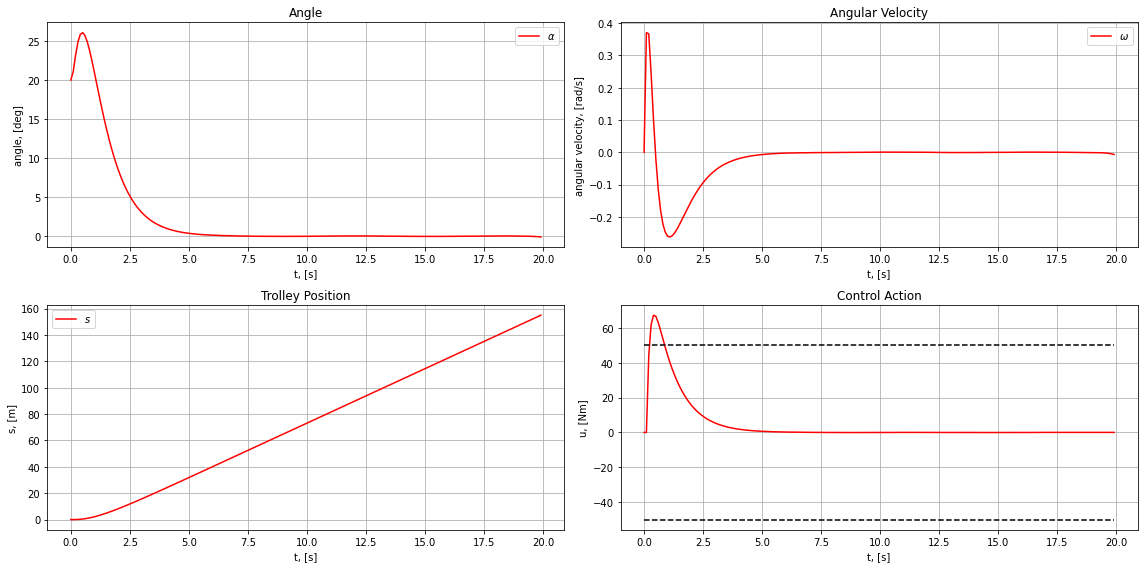

In [15]:
u = np.zeros(sim.loop_count)
u_optimized = np.zeros(mpc.p_horizon)
states = np.zeros((sim.loop_count, 4))

# инициализация
states[0, :] = np.array([ np.pi * 20 / 180, 0, 0, 0])
if sim.output:
    print('current_state:', states[0, :] )

for i in range(1, sim.loop_count):
    ts = [sim.step * (i-1), sim.step * i]
    sol_i = solve_ivp(lambda t, x: rhs(t, x, u[i]), ts, states[i-1, :])
    states[i, :] = sol_i.y.T[-1]
    if sim.output:
        print('current_state:', states[i, :])
    
    # инициализация
    len_to_end = min(mpc.p_horizon, sim.loop_count - i)
    u_mpc0 = np.zeros(len_to_end)
    u_mpc0 = u_optimized[0: min(len_to_end, mpc.p_horizon)]
    
    solution = minimize(cost_function_complex, u_mpc0, method='SLSQP')
    u_optimized = solution.x  

    if i < sim.loop_count - 1:
        u[i+1] = u_optimized[0]
        
plot_results(sim.t, states, u, cnst)

### Условная оптимизация
Цикл по тактам управления, внутри каждого из которых решается задача оптимизации c целевой функцией $cost\_function\_simple$, определенной выше и с ограничением на управление $|u| \leq cnst.u\_max$. 

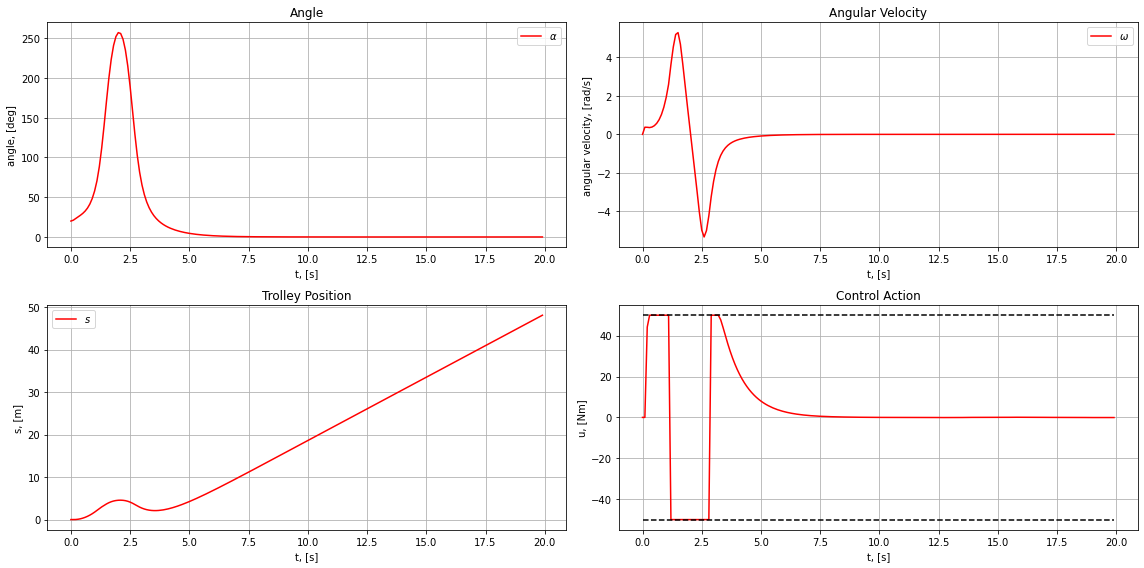

In [16]:
u = np.zeros(sim.loop_count)
u_optimized = np.zeros(mpc.p_horizon)
states = np.zeros((sim.loop_count, 4))

# ограничения для оптимизации
c1 = ({'type':'ineq', 'fun': lambda u: -np.abs(u) + cnst.u_max})
cons = [c1]

# инициализация
states[0, :] = np.array([ np.pi * 20 / 180, 0, 0, 0])
if sim.output:
    print('current_state:', states[0, :] )

for i in range(1, sim.loop_count):
    ts = [sim.step * (i-1), sim.step * i]
    sol_i = solve_ivp(lambda t, x: rhs(t, x, u[i]), ts, states[i-1, :])
    states[i, :] = sol_i.y.T[-1]
    if sim.output:
        print('current_state:', states[i, :])
    
    # инициализация
    len_to_end = min(mpc.p_horizon, sim.loop_count - i)
    u_mpc0 = np.zeros(len_to_end)
    u_mpc0 = u_optimized[0: min(len_to_end, mpc.p_horizon)]
    
    solution = minimize(cost_function_simple, u_mpc0, method='SLSQP', constraints=cons)
    u_optimized = solution.x  

    if i < sim.loop_count - 1:
        u[i+1] = u_optimized[0]
        
plot_results(sim.t, states, u, cnst)

### Библиотеки, реализующие MPC

[Model predictive control python toolbox](https://www.do-mpc.com/en/latest/)

[GEKKO](https://gekko.readthedocs.io/en/latest/imode.html?highlight=mpc#mpc)

[Dynamics and control with jupyter notebooks](https://dynamics-and-control.readthedocs.io/en/latest/2_Control/7_Multivariable_control/Simple%20MPC.html)